# Mac Address Analysis

The mac addresss can be used to understand the type of devices held by the customer. A csv was downloaded from the official IEEE website which contains a list of the first 6 letters of the mac address and the company which they are associated with.

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

from msci.utils import utils, plot
from msci.cleaning.clean_data import remove_sparse_data

In [1]:
%load_ext autoreload
%autoreload 2

## Import the data and the mac addresses

In [3]:
signal_df = utils.import_signals('Mall of Mauritius')

In [51]:
mac_address_df = utils.import_mac_addresses()

## Add manufacturer to signal_df

In [39]:
signal_df['manufacturer'] = utils.add_device_type_signal(signal_df)

## Manufacturer Analysis

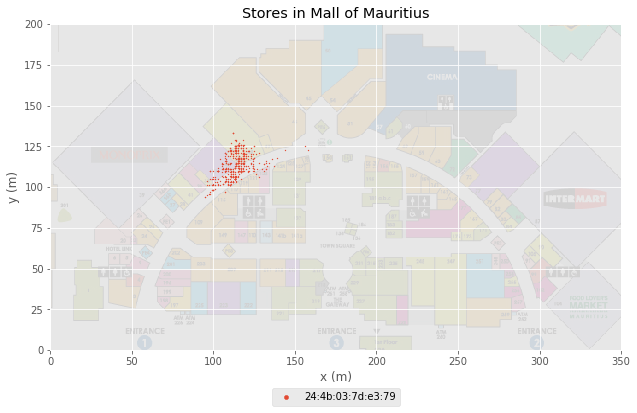

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
plot.plot_path_inline(signal_df, signal_df.mac_address[0], ax=axes)

In [ ]:
signal_df.manufacturer.value_counts()[:30]

In [ ]:
signal_df.groupby('mac_address').head(1).manufacturer.value_counts()[:30]

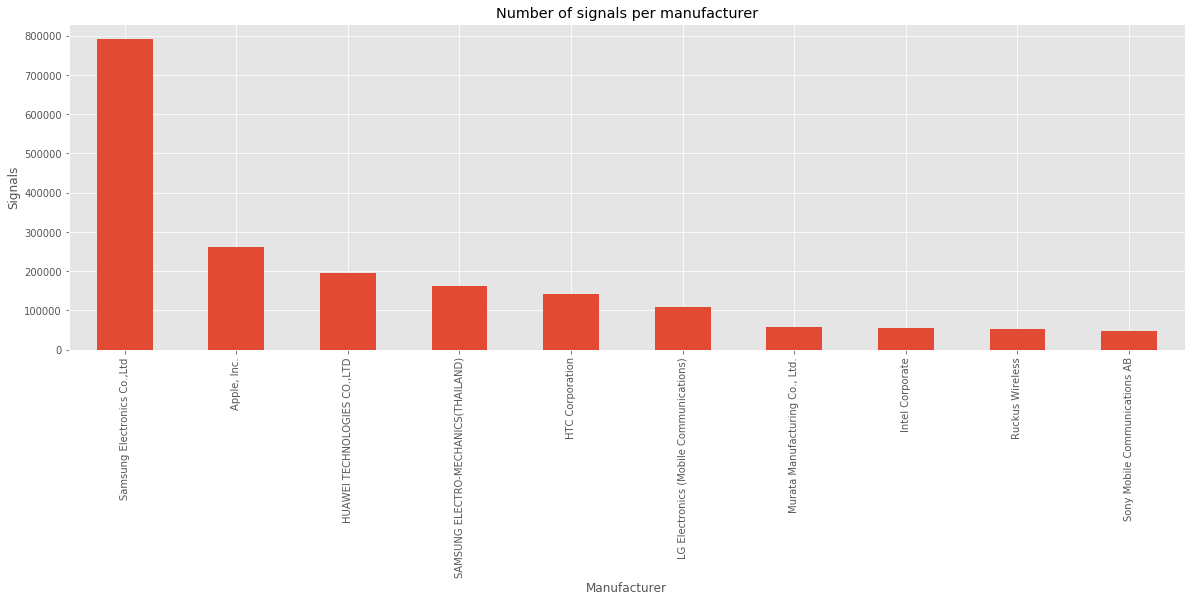

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
ax = signal_df.manufacturer.value_counts()[0:10].plot.bar(ax=axes)
ax.set_title('Number of signals per manufacturer')
ax.set_xlabel('Manufacturer')
ax.set_ylabel('Signals');

### Number of signals against time

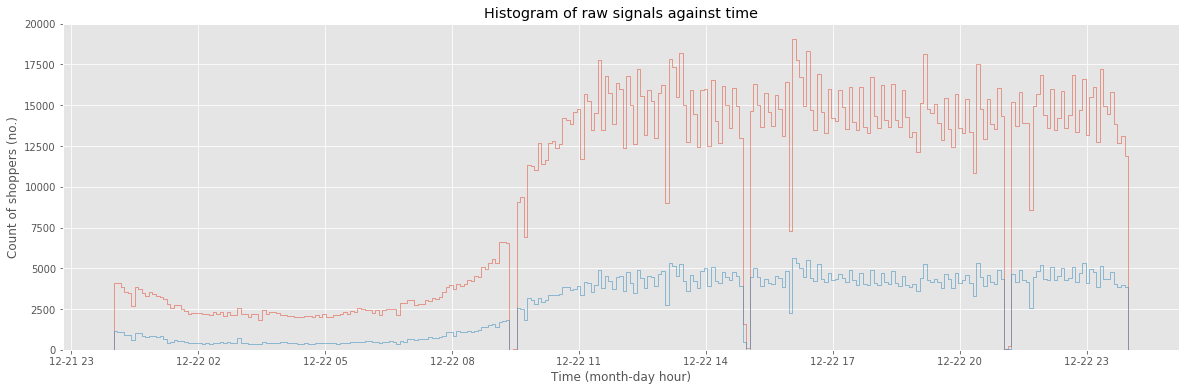

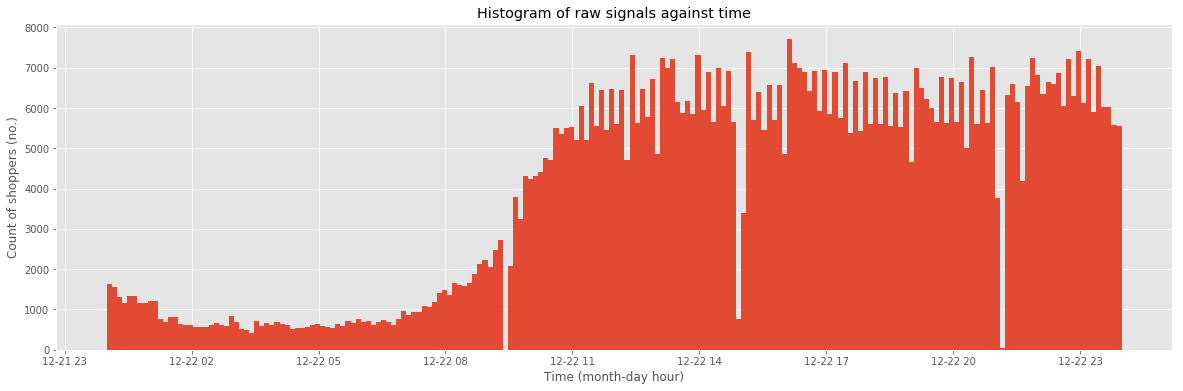

In [41]:
COMPANY = 'Samsung Electronics Co.,Ltd'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

signal_bins = int((signal_df.date_time.max() - signal_df.date_time.min()).seconds / (60 * 5))
signal_df.date_time.hist(bins=signal_bins, ax=axes, histtype='step')

company_signal_df = signal_df[signal_df.manufacturer == COMPANY]

company_bins = int((company_signal_df.date_time.max() - company_signal_df.date_time.min()).seconds / (60 * 5))
company_signal_df.date_time.hist(bins=company_bins, ax=axes, histtype='step')

axes.set_title('Histogram of raw signals against time')
axes.set_xlabel('Time (month-day hour)')
axes.set_ylabel('Count of shoppers (no.)')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

ax = company_signal_df.date_time.hist(bins=200, ax=axes)
ax.set_title('Histogram of raw signals against time')
ax.set_xlabel('Time (month-day hour)')
ax.set_ylabel('Count of shoppers (no.)');

### Number of mac addresses against time

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


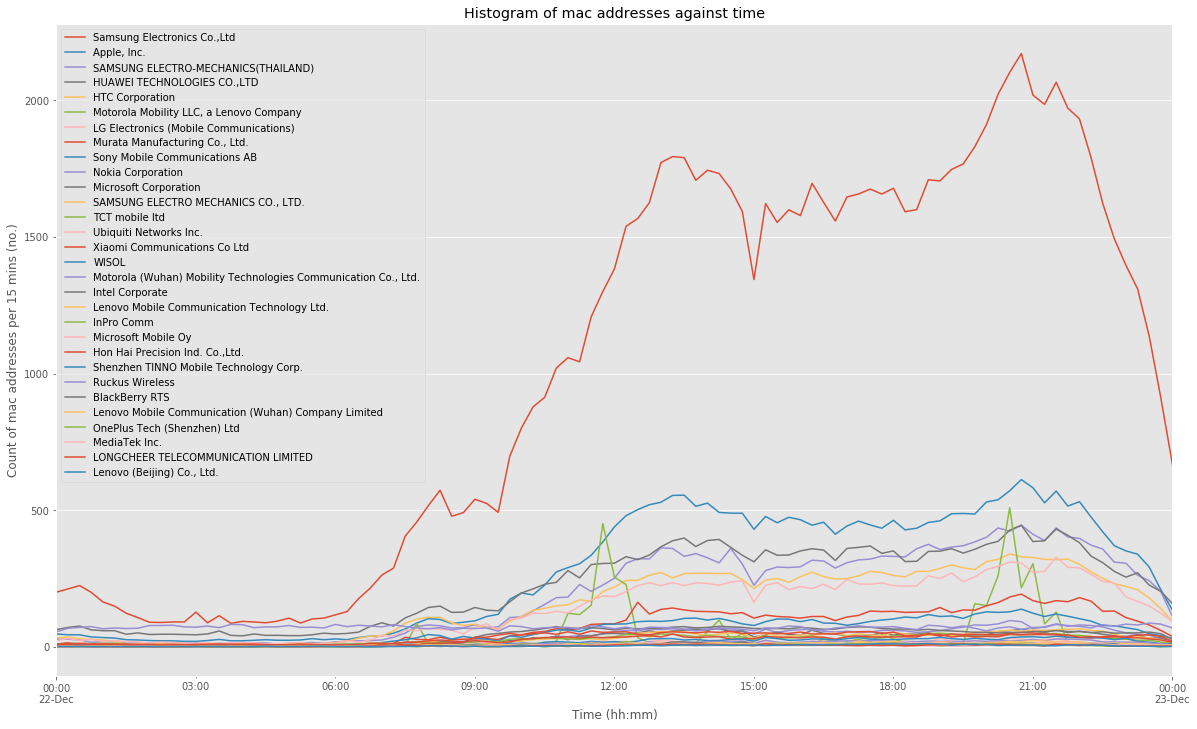

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

for company in signal_df.groupby('mac_address').head(1).manufacturer.value_counts()[:30].index:
    company_signal_df = signal_df[signal_df.manufacturer == company]
    plot.plot_histogram_jn(company_signal_df, axes=axes, label=company)

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


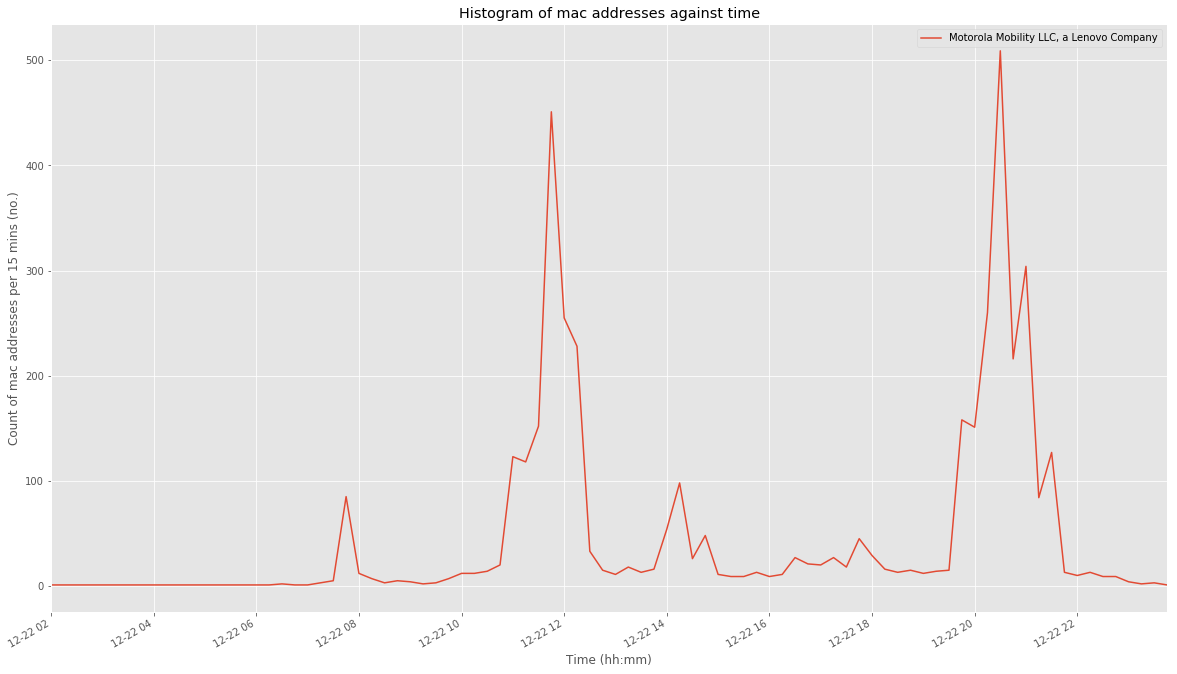

In [45]:
minute_resolution = '15'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))
company = 'Motorola Mobility LLC, a Lenovo Company'
company_signal_df = signal_df[signal_df.manufacturer == company]
plot.plot_histogram_jn(company_signal_df, axes=axes, label=company)

In [48]:
signal_clean_df = remove_sparse_data(signal_df, 100)

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


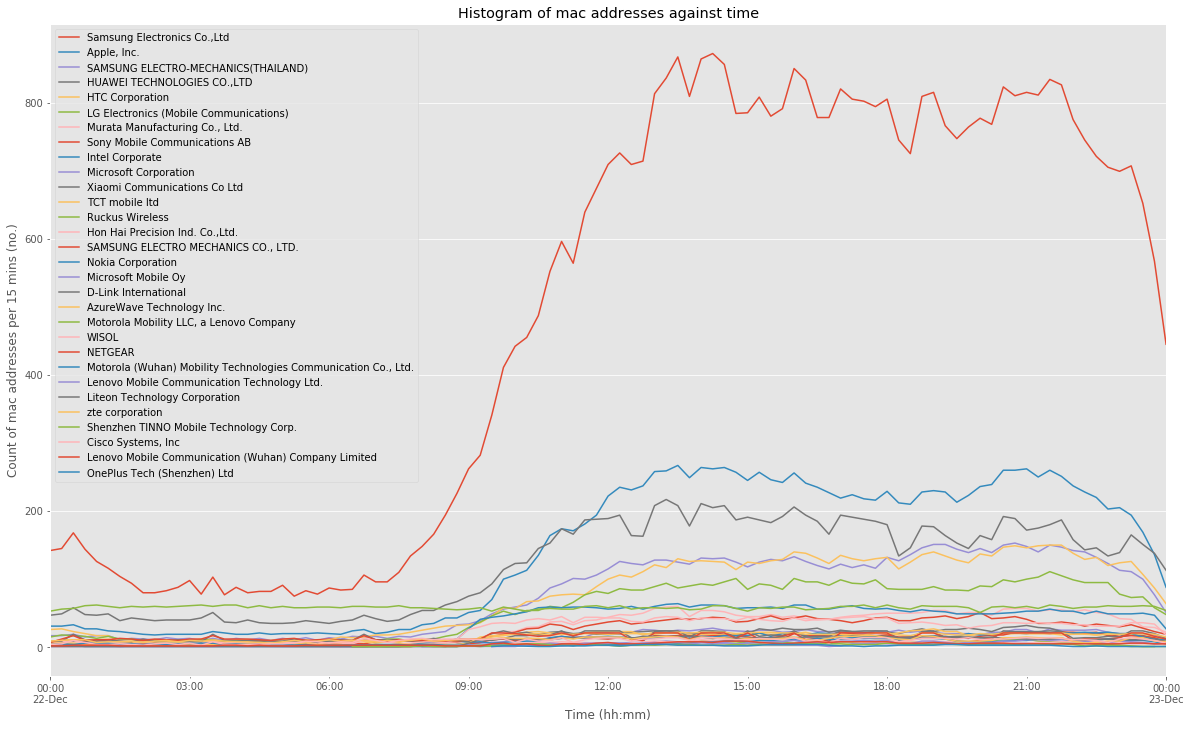

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

for company in signal_clean_df.groupby('mac_address').head(1).manufacturer.value_counts()[:30].index:
    company_signal_df = signal_clean_df[signal_clean_df.manufacturer == company]
    plot.plot_histogram_jn(company_signal_df, axes=axes, label=company)